In [81]:
"""
@author: jack

DESCRIPTION
======
This performs the standard S-BOS method, along with some preprocessing and 
postprocessing.

INSTRUCTIONS
======
When the scipt is run it will prompt the user with a dialog to select an 
image to process.  For the reference image, it will automatically open 
the image in the directory that is titled 'reference.jpg'.

It will then ask the user if they would like to remove the 'non-periodic 
component' of the image.  If they select yes, the script will subtract 
low frequency content from the image.

After the image has been processed, the user is offered the option to save the 
results.
"""


"\n@author: jack\n\nDESCRIPTION\n======\nThis performs the standard S-BOS method, along with some preprocessing and \npostprocessing.\n\nINSTRUCTIONS\n======\nWhen the scipt is run it will prompt the user with a dialog to select an \nimage to process.  For the reference image, it will automatically open \nthe image in the directory that is titled 'reference.jpg'.\n\nIt will then ask the user if they would like to remove the 'non-periodic \ncomponent' of the image.  If they select yes, the script will subtract \nlow frequency content from the image.\n\nAfter the image has been processed, the user is offered the option to save the \nresults.\n"

In [82]:

import numpy as np
#import cv2
from imageio.v3 import imread, imwrite
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import timeit
import csv
from matplotlib import pyplot as plt
import scipy
from scipy.signal import kaiserord, lfilter, firwin, freqz
import openpiv.tools
import openpiv.pyprocess as process
#closeall = plt.close('all')



In [83]:

# #------------------------------------------------------------
# # open image
# def open_image():
#     Tk().withdraw()
#     file_opt = options = {}
#     #options['initialdir'] = '/home/jack/Pictures'
#     options['title'] = 'Select an image to process'
#     imgFilename = askopenfilenames(**file_opt)
#     fo = 1
#     filepath = str(imgFilename)
#     filepath = filepath[:-4]
#     while fo:
#         filepath = filepath[:-1]
#         if filepath[-1] == '/':
#             fo = 0
#     refImgFilename = filepath + "reference.JPG')"
#     imgFilename = str(imgFilename)[2:-3]
#     refImgFilename = str(refImgFilename[2:-2])
#     print(imgFilename)
#     print(refImgFilename)
#     return(imgFilename, refImgFilename)



In [84]:

#------------------------------------------------------------
# determine the orientation of the periodic pattern
def determine_orientation(image):
    Hwave = image[:,int(width/2)]
    Vwave = image[int(height/2),:]
    # take fft
    Hfft = np.fft.fft(Hwave, n=None, axis=-1, norm=None)
    Vfft = np.fft.fft(Vwave, n=None, axis=-1, norm=None)
    
    if max(Hfft[2:200]) > max(Vfft[2:200]):
        orientation = 'H'
    else:
        orientation = 'V'
    return(orientation)


In [85]:


#------------------------------------------------------------
# allow user to select where to crop the image
#def crop_image(image):
    # NOTE: THIS WAS A PLACEHOLDER FOR A FUNCTION I DIDN'T GET AROUND TO
    
    

#------------------------------------------------------------
# display image
def display_image(image):
    plt.figure()
    X = [ (1,2,1), (2,2,2), (2,2,4) ]
    for nrows, ncols, plot_number in X:
        plt.subplot(nrows, ncols, plot_number)
        if plot_number == 1:
            imgMean = np.mean(image.ravel())
            imgStd = np.std(image.ravel())
            clim = (imgMean-2*imgStd,imgMean+2*imgStd)
            print(clim)
            plt.imshow(image, cmap='gray', clim=clim, interpolation='none')
            plt.title('image')
        if plot_number == 2:
            plt.hist(image.ravel(), 256)
            plt.title('histogram')
        if plot_number == 4:
                if orientation == 'H' or orientation == 'h':
                    plt.plot(image[:,int(width/2)])
                else:
                    plt.plot(image[int(height/2),:])
                plt.title('waveform')
        plt.show()



In [86]:
# use fft to find the wavelength of the background pattern
def find_wavelength(image,orientation):
    start = timeit.default_timer()
    if orientation == 'H' or orientation == 'h':
        BGwaveform = image[:,int(width/2)]
    else:
        BGwaveform = image[int(height/2),:]
    # take fft
    fftOut = np.fft.fft(BGwaveform, n=None, axis=-1, norm=None)
    
    N = len(BGwaveform)
    xf = np.linspace(0.0, 0.5, N//2)
    yf = 2.0/N*np.abs(fftOut[0:N//2])
    maxIndex = np.argmax(yf[2:])
    wavelength = 1/xf[maxIndex+2]
    #plt.figure()
    #plt.plot(xf,yf,'x-')
    stop = timeit.default_timer()
    print('the wavelength of the pattern is ' + str(wavelength) + ' px.')
    print('time to refine wavelength: ' + str(stop-start) + ' s.')
    # add the ability  to find the phase
    return(wavelength)



In [87]:

#------------------------------------------------------------
# use correlate to get a more precise wavelength
def refine_wavelength(image, wavelength, orientation):
    start = timeit.default_timer()
    if orientation == 'H' or orientation == 'h':
        v1 = image[:,int(width/2)]
    else:
        v1 = image[int(height/2),:]
    
    x = np.array(range(int(wavelength*100)))
    count = 0
    shift = np.linspace(-wavelength/3, wavelength/3, 100)
    maxcor = np.zeros(len(shift))
    
    for i in shift:
        WL = wavelength+i
        v2 = np.sin(x*(2*np.pi)/WL)
    
        cor = np.correlate(v1, v2, mode='full')
    
        maxcor[count] = np.max(cor)
        count = count + 1
    
    #plt.figure()
    #plt.plot(shift,maxcor)
    newwavelength = wavelength + shift[np.argmax(maxcor)]
    print('the wavelength is ' + str(newwavelength))
    
    stop = timeit.default_timer()
    print('time to find wavelength: ' + str(stop-start) + ' s.')
    return(newwavelength)



In [88]:

#------------------------------------------------------------
# use correlation to find the phase
def find_phase(image, wavelength, orientation):
    if orientation == 'H' or orientation == 'h':
        v1 = image[:,int(width/2)]
    else:
        v1 = image[int(height/2),:]
    
    x = np.array(range(int(6*wavelength)))
    y = np.sin((x)*(2*np.pi)/wavelength)
    
    cor = np.correlate(y[0:int(2*wavelength)], v1, mode='valid')
    
    phaseoffset = wavelength - (len(cor) - np.argmax(cor*range(len(cor))) - 1)
    print('the phase shift is ' + str(phaseoffset))
    return(phaseoffset)



In [89]:

#------------------------------------------------------------
# apply a filter to find the nonperiodic component of the background
def find_nonperiodic_componant(image,wavelength, orientation):
    start = timeit.default_timer()
    sigma = wavelength*2
    nonPeriodicComp = scipy.ndimage.gaussian_filter(image, sigma, order=0)
    stop = timeit.default_timer()
    print('time to find nonperiodic componant: ' + str(stop-start) + ' s.')
    return(nonPeriodicComp)



In [90]:

#------------------------------------------------------------
# blur to remove noise
def remove_noise(image,wavelength,sigmaPerWavelength):
    start = timeit.default_timer()
    sigma = wavelength*sigmaPerWavelength
    smoothedImage = scipy.ndimage.gaussian_filter(image, sigma, order=0)
    stop = timeit.default_timer()
    print('time to smooth image: ' + str(stop-start) + ' s.')
    return(smoothedImage)


#------------------------------------------------------------
# function to perform BOS
def perform_bos(Iimg, Iref, orientation):
    start = timeit.default_timer()
    Iimg = scale(np.float32(Iimg))
    Iref = scale(np.float32(Iref))
    
    if orientation == 'H' or orientation == 'h':
        orient = 0
    else:
        orient = 1
    # take gradient of the image
    Igrad = np.gradient(Iimg, axis=orient)
    # take gradient of the reference image
    Irefgrad = np.gradient(Iref, axis=orient)
    # average the gradients
    Iavggrad = (Igrad + Irefgrad)/2
    # find difference between image and ref image
    Idiff = Iimg-Iref
    # output
    Iout = Iavggrad*Idiff
    stop = timeit.default_timer()
    print('time to perform S-BOS: ' + str(stop-start) + ' s.')
    return Iout, Iavggrad, Idiff


#------------------------------------------------------------
# adjust brightness so mean is zero
def scale(image):
    start = timeit.default_timer()
    image = image - np.amin(image)
    image = image/np.amax(image)
    image = 2*image - np.mean(2*image.ravel())
    stop = timeit.default_timer()
    print('time to scale image: ' + str(stop-start) + ' s.')
    return image



In [91]:
import cv2
#------------------------------------------------------------
# imgFilename = '../raw_images/dots/30cm/5percent/DSC_0780.JPG'
# refImgFilename = '../raw_images/dots/30cm/5percent/reference.JPG'

imgFilename = '/media/user/ExtremePro/1MHz_Large/C001H001S0001/C001H001S0001005184.tif'
refImgFilename = '/media/user/ExtremePro/1MHz_Large/C001H001S0001/C001H001S0001000001.tif'


Img = imread(imgFilename)
refImg = imread(refImgFilename)

Img = Img[500:900,200:700]
refImg = refImg[500:900,200:700]

height,width = refImg.shape
orientation = determine_orientation(refImg)
Img = np.float32(Img)
refImg = np.float32(refImg)


In [92]:


#------------------------------------------------------------
# add a function to crop the image
left = 0
right = width
top = 0
bottom = height
Img = Img[top:bottom,left:right]
refImg = refImg[top:bottom,left:right]
height,width = refImg.shape


V
the wavelength of the pattern is 99.6 px.
time to refine wavelength: 0.00012717900244751945 s.
the wavelength is 94.56969696969696
time to find wavelength: 0.07815567799843848 s.
time to find nonperiodic componant: 0.3072942310027429 s.
(105.48504638671875, 124.07379150390625)


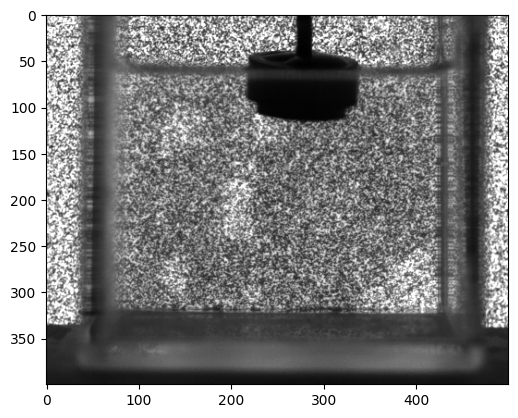

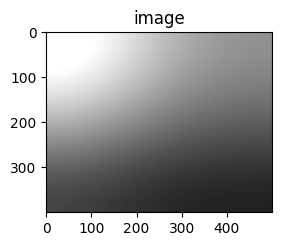

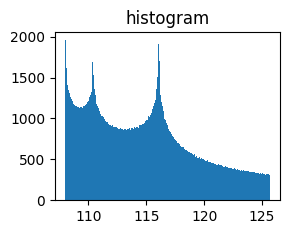

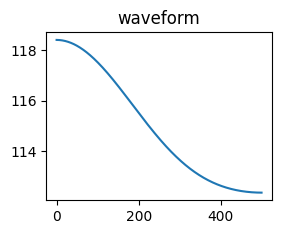

the wavelength of the pattern is 99.6 px.
time to refine wavelength: 0.00010823499906109646 s.
time to scale image: 0.0006526900033350103 s.
time to scale image: 0.00034439000592101365 s.
time to smooth image: 0.008769891996053047 s.
time to smooth image: 0.011028590000933036 s.
time to scale image: 0.0005972789949737489 s.
time to scale image: 0.0004736970004159957 s.
time to perform S-BOS: 0.002112777001457289 s.
(-4.993516085960437e-06, 1.772949235601118e-05)


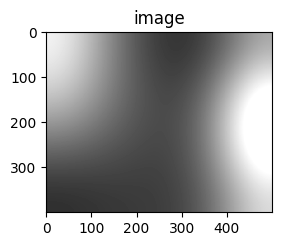

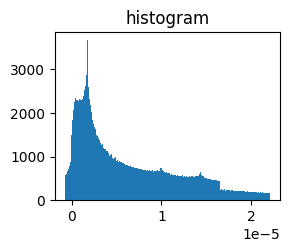

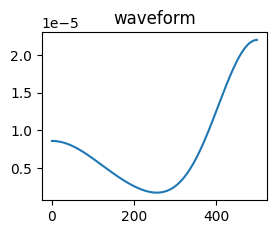

In [93]:

plt.figure()
plt.imshow(refImg,cmap='gray')
orientation = determine_orientation(refImg)
print(orientation)


#------------------------------------------------------------
# find the nonperiodic component of the image

# ask user if they would like to save files
wavelength = find_wavelength(refImg,orientation)
wavelength = refine_wavelength(refImg, wavelength, orientation)
msg = ('Would you like to subtract the non-periodic component of the images?')
npcChoice = True
if npcChoice:
    NPC = find_nonperiodic_componant(refImg,wavelength,orientation)
    display_image(NPC)
    Img = Img - NPC
    refImg = refImg - NPC
else:
    print('You have chosen not to subtract the nonperiodic component')   


#------------------------------------------------------------
# perform various preprocessing operations
wavelength = find_wavelength(refImg,orientation)

#display_image(Img)
#display_image(refImg)

Img = scale(Img)
refImg = scale(refImg)

sigmaPerWavelength = 1.0/16.0
Img = remove_noise(Img, wavelength, sigmaPerWavelength)
refImg = remove_noise(refImg, wavelength, sigmaPerWavelength)

#display_image(Img)
#display_image(refImg)

Iout, Iavggrad, Idiff = perform_bos(Img, refImg, orientation)

#display_image(Iout)
#plt.show()


# blur image to remove S-BOS artifacts
sigma = wavelength
fIout = scipy.ndimage.gaussian_filter(Iout, sigma, order=0)
display_image(fIout)

